In [11]:
## Import Packages
import numpy as np
import _pickle as pk
from matplotlib import pyplot as plt
import matplotlib as mpl
from netCDF4 import Dataset
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point
import scipy.stats as stats

plt.rcParams['axes.xmargin'] = 0 #default margin spacing for the edges
mpl.rc('font',size=40,**{'family':'sans-serif','sans-serif':['Arial']})
%matplotlib inline

In [12]:
#load in cloud feedbacks and dimensions as needed
Models = ['CanESM2','CanESM5_p2']
Source = '/Volumes/eSSD0/Papers/GMD_CanESM_p1/'
fbk = ['TrCLlw_FLUX_FB_MZdecomp','TrCLsw_FLUX_FB_MZdecomp']
fbk_new = ['LW','SW']

lat = np.linspace(-87.864,87.864,64)
lon = np.linspace(0,357.1875,128)

y = lat*np.pi/180
coslat = np.cos(y)
coslat = np.tile(coslat,(lon.size,1)).T

data = dict()
for m in range(len(Models)):
    data[Models[m]] = dict()
    for f in range(2):
        data[Models[m]][fbk_new[f]] = pk.load(open(\
        Source+'Data/'+Models[m]+'/Fluxes/'+Models[m]+'_'+fbk[f]+'_Grid.pi','rb'))

In [13]:
fbk_adj = ['TrCLlw_FLUX_FB','TrCLsw_FLUX_FB']

data_adjust = dict()
for m in range(len(Models)):
    data_adjust[Models[m]] = dict()
    for f in range(2):
        data_adjust[Models[m]][fbk_new[f]] = pk.load(open(\
            Source+'Data/'+Models[m]+'/Fluxes/'+Models[m]+'_'+fbk_adj[f]+'_Grid.pi','rb'))
        
        data_adjust[Models[m]][fbk_new[f]].pop('CAM3')
        data_adjust[Models[m]][fbk_new[f]].pop('CAM5')
        data_adjust[Models[m]][fbk_new[f]].pop('ECHAM6_ctr')
        
        data_adjust[Models[m]][fbk_new[f]] = np.mean(np.stack(list(\
            data_adjust[Models[m]][fbk_new[f]].values()),axis=0),axis=0)

In [14]:
data_adj_reshape = dict()
data_adj_rebuild = dict()
data_reshape = dict()
data_rebuild = dict()
for mods in data.keys():
    data_adj_reshape[mods] = dict()
    data_reshape[mods] = dict()
    data_adj_rebuild[mods] = dict()
    data_rebuild[mods] = dict()
    for fbk in data[mods].keys():
        data_adj_reshape[mods][fbk] = data_adjust[mods][fbk].reshape(64*128)
        data_reshape[mods][fbk] = data[mods][fbk]['Standard']['All'].reshape(64*128)
            
        data_rebuild[mods][fbk] = data_reshape[mods][fbk].reshape(64,128)
        data_adj_rebuild[mods][fbk] = data_adj_reshape[mods][fbk].reshape(64,128)
    
    data_rebuild[mods] = data_rebuild[mods]['LW']+data_rebuild[mods]['SW']
    data_adj_rebuild[mods] = data_adj_rebuild[mods]['LW']+data_adj_rebuild[mods]['SW']
    
    data_reshape[mods] = data_reshape[mods]['LW']+data_reshape[mods]['SW']
    data_adj_reshape[mods] = data_adj_reshape[mods]['LW']+data_adj_reshape[mods]['SW']

In [15]:
r = dict()
for mods in data_reshape.keys():
    r[mods] = stats.pearsonr(data_reshape[mods],data_adj_reshape[mods])

In [16]:
for mods in r.keys():
    print('\n',mods, '\n')
    print('r-value - ',r[mods][0],'\n p-value = ',r[mods][1])


 CanESM2 

r-value -  0.7204919589395251 
 p-value =  0.0

 CanESM5_p2 

r-value -  0.861372184767037 
 p-value =  0.0


In [17]:
print('ADJUST-CRE')
for mods in r.keys():
    print('\n',mods, '\n')
    print('\n global mean - ',np.average(data_adj_rebuild[mods],weights=coslat))
        
print('\n KERNEL')
for mods in r.keys():
    print('\n',mods, '\n')
    print('\n global mean - ',np.average(data_rebuild[mods],weights=coslat))

ADJUST-CRE

 CanESM2 


 global mean -  0.5199348847704633

 CanESM5_p2 


 global mean -  0.8571401625804567

 KERNEL

 CanESM2 


 global mean -  0.48511067887255493

 CanESM5_p2 


 global mean -  0.7924783421426211


In [18]:
data_adj_plot = dict()
data_plot = dict()
for mods in data.keys():
    data_adj_plot[mods],lon_cyc = add_cyclic_point(np.concatenate((\
        data_adj_rebuild[mods][:,64:128],\
        data_adj_rebuild[mods][:,0:64]),axis=1),lon)
                                                           
                                                           
    data_plot[mods],lon_cyc = add_cyclic_point(np.concatenate((\
        data_rebuild[mods][:,64:128],\
        data_rebuild[mods][:,0:64]),axis=1),lon)

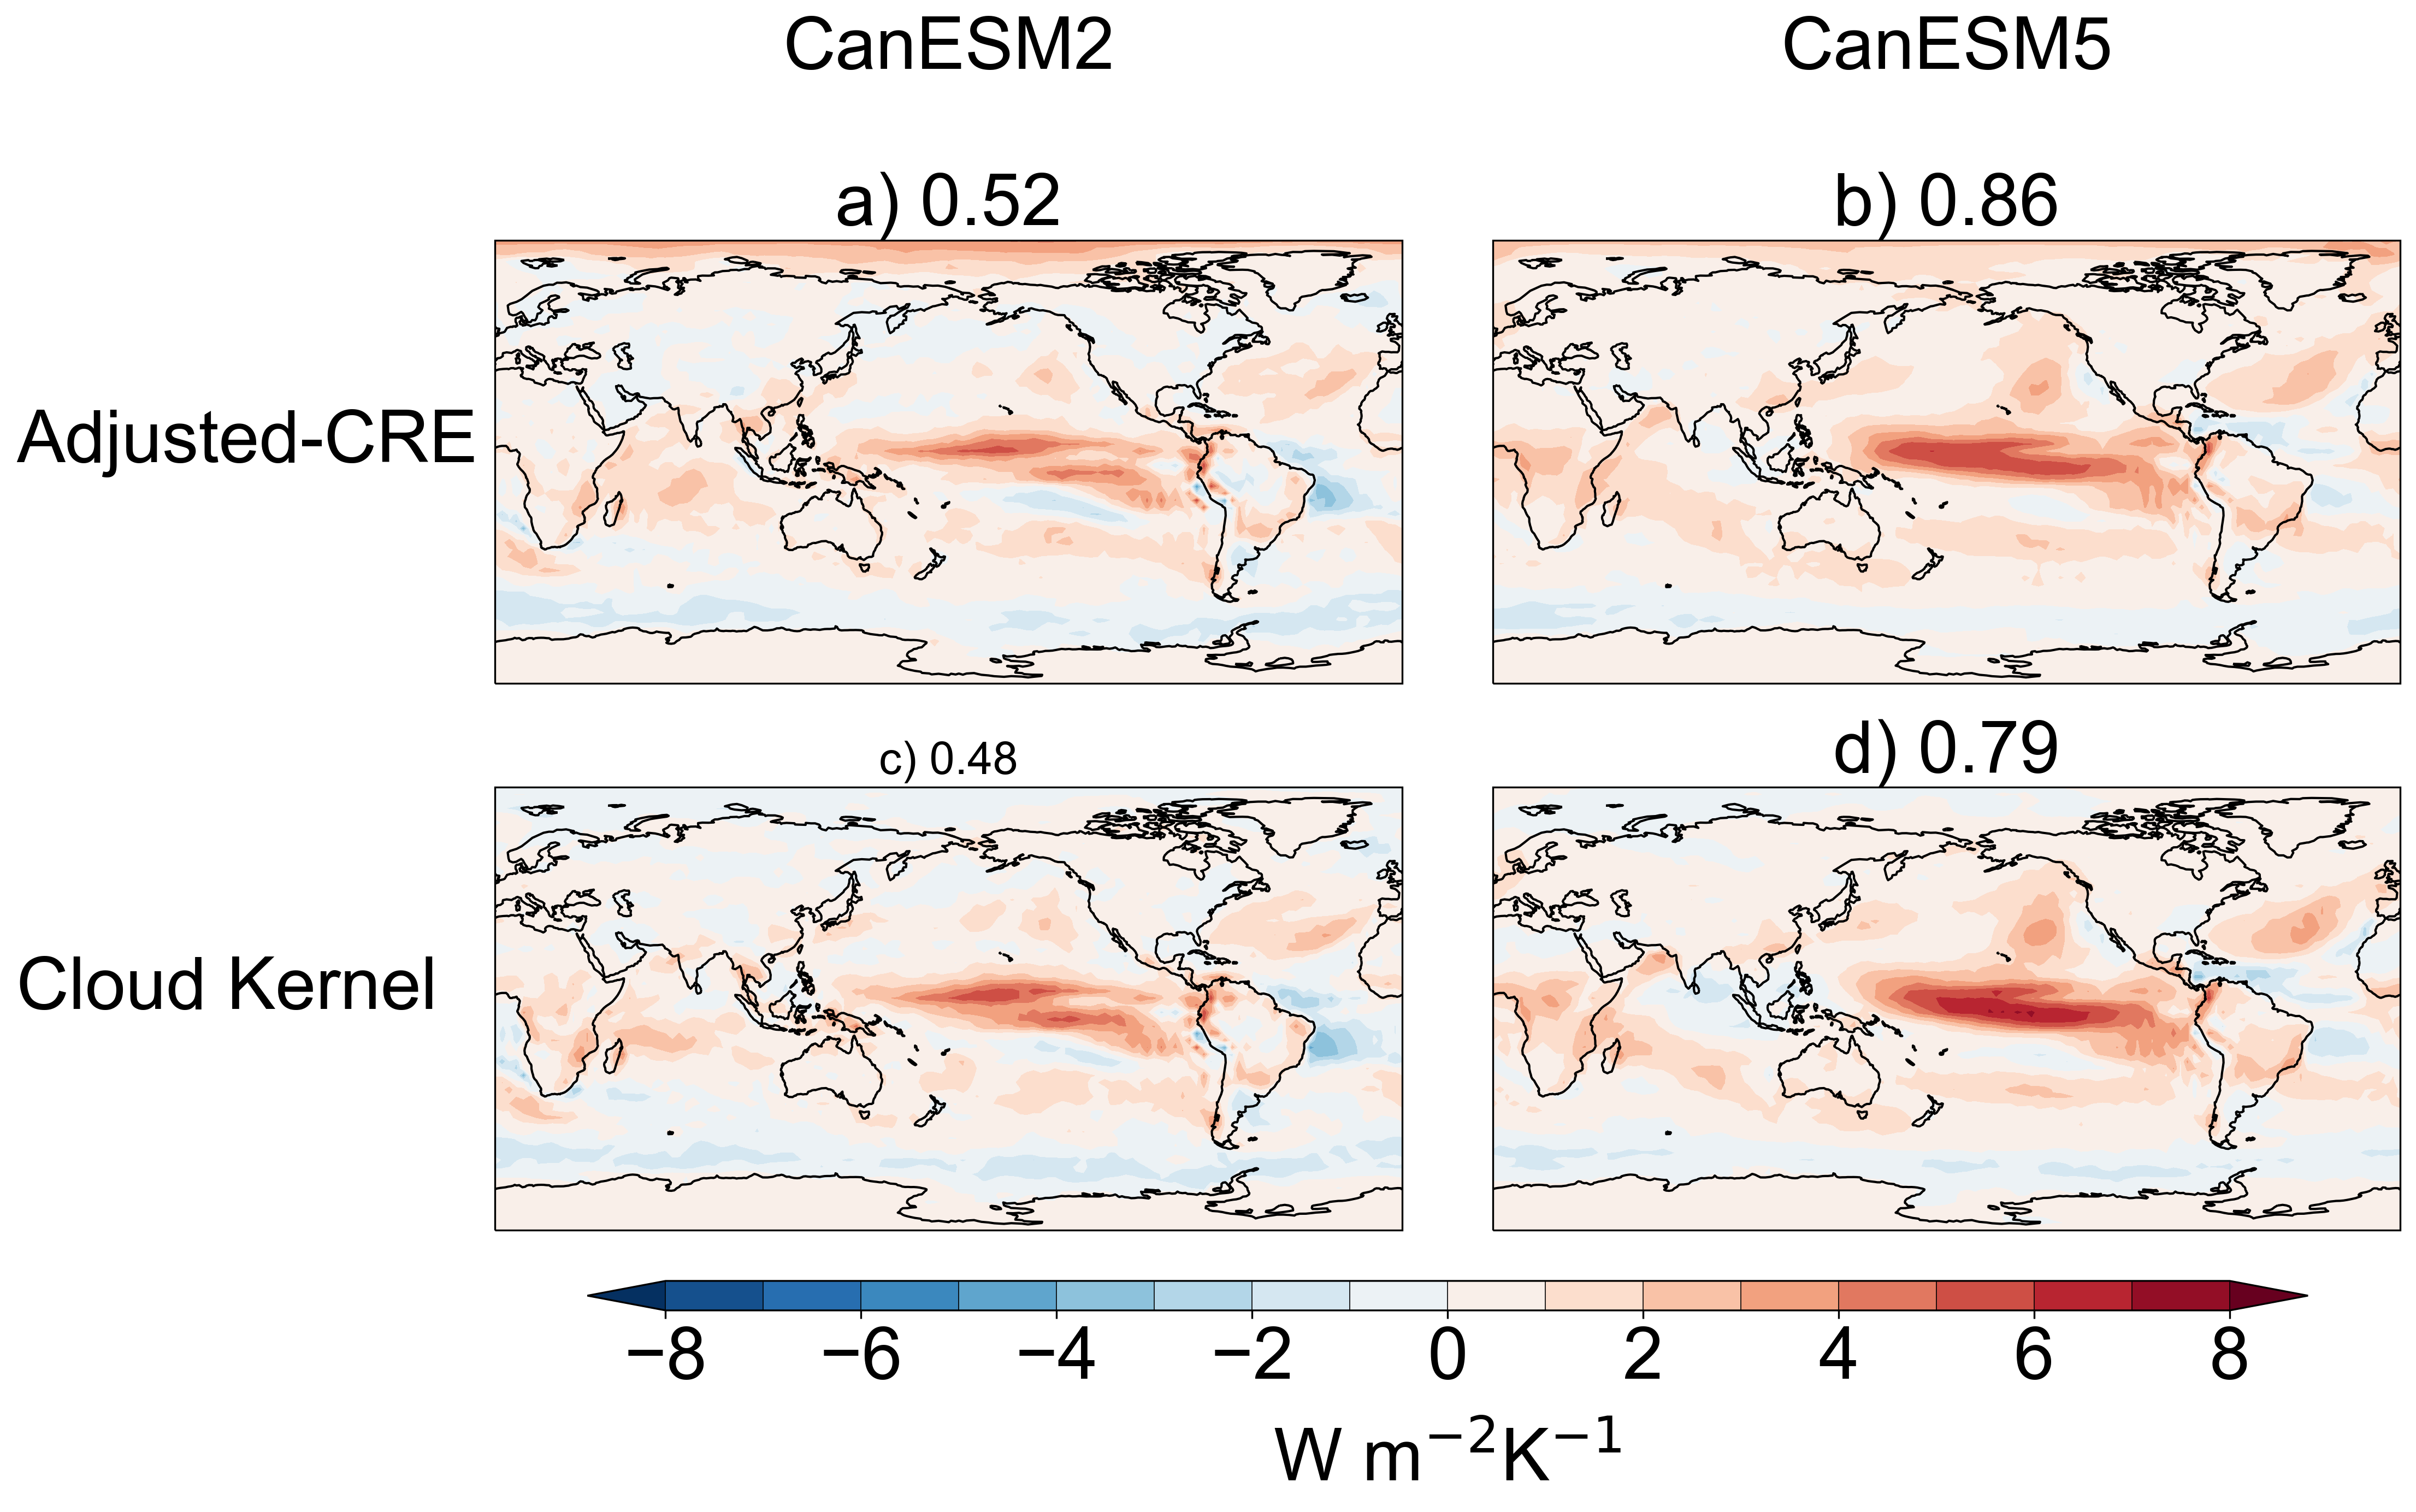

In [21]:
fig = plt.figure(figsize=(15,9),dpi=300)
bounds = np.arange(-8,8.1)
bounds_ticks = np.arange(-8,8.1,2)
cmap = plt.cm.RdBu_r
bounds2 = np.append(np.append(-500,bounds),500)
norm = mpl.colors.BoundaryNorm(bounds2, cmap.N)

#esm2 - adjusted
ax1 = plt.subplot(221,projection=ccrs.PlateCarree(central_longitude=180))
im1 = ax1.contourf(lon_cyc,lat,data_adj_plot['CanESM2'],\
                   bounds,cmap=cmap,norm=norm,extend='both')
ax1.coastlines()
plt.title('CanESM2\n\na) 0.52',fontsize=32)
plt.text(-370,0,'Adjusted-CRE',fontsize=32)

#esm2 - adjusted
ax2 = plt.subplot(222,projection=ccrs.PlateCarree(central_longitude=180))
im2 = ax2.contourf(lon_cyc,lat,data_adj_plot['CanESM5_p2'],\
                   bounds,cmap=cmap,norm=norm,extend='both')
ax2.coastlines()
plt.title('CanESM5\n\nb) 0.86',fontsize=32)

#esm2 - kernel
ax3 = plt.subplot(223,projection=ccrs.PlateCarree(central_longitude=180))
im3 = ax3.contourf(lon_cyc,lat,data_plot['CanESM2'],\
                   bounds,cmap=cmap,norm=norm,extend='both')
ax3.coastlines()
plt.title('c) 0.48',fontsize=20)
plt.text(-370,0,'Cloud Kernel',fontsize=32)

#esm2 - kernel
ax4 = plt.subplot(224,projection=ccrs.PlateCarree(central_longitude=180))
im4 = ax4.contourf(lon_cyc,lat,data_plot['CanESM5_p2'],\
                   bounds,cmap=cmap,norm=norm,extend='both')
ax4.coastlines()
plt.title('d) 0.79',fontsize=32)

plt.subplots_adjust(wspace=0.1)

#add colorbar
plt.subplots_adjust(bottom=0.2)
cbar_ax = fig.add_axes([0.1625, 0.15, 0.7, 0.02]) #left bottom width height
cbar = fig.colorbar(im1,cbar_ax,orientation='horizontal',ticks=bounds_ticks,drawedges=True)
cbar.ax.tick_params(labelsize=32)
cbar.set_label('W m$^{-2}$K$^{-1}$',labelpad=15,fontsize=32)

plt.savefig('cld_fbk_Methods_comp.png',bbox_inches='tight')

fig = plt.figure(figsize=(15,9),dpi=300)
plt.suptitle('CanESM5',fontsize=20)
bounds = np.arange(-12,12.1)
bounds_ticks = np.arange(-12,12.1,4)
cmap = plt.cm.RdBu_r
bounds2 = np.append(np.append(-500,bounds),500)
norm = mpl.colors.BoundaryNorm(bounds2, cmap.N)

#esm2 - adjusted
ax1 = plt.subplot(221,projection=ccrs.PlateCarree(central_longitude=180))
im1 = ax1.contourf(lon_cyc,lat,data_adj_plot['CanESM5_p2']['LW'],\
                   bounds,cmap=cmap,norm=norm,extend='both')
ax1.coastlines()
plt.title('LW adjusted-CRE [0.79]',fontsize=20)

#esm2 - adjusted
ax2 = plt.subplot(222,projection=ccrs.PlateCarree(central_longitude=180))
im2 = ax2.contourf(lon_cyc,lat,data_adj_plot['CanESM5_p2']['SW'],\
                   bounds,cmap=cmap,norm=norm,extend='both')
ax2.coastlines()
plt.title('SW adjusted-CRE [0.06]',fontsize=20)

#esm2 - kernel
ax3 = plt.subplot(223,projection=ccrs.PlateCarree(central_longitude=180))
im3 = ax3.contourf(lon_cyc,lat,data_plot['CanESM5_p2']['LW'],\
                   bounds,cmap=cmap,norm=norm,extend='both')
ax3.coastlines()
plt.title('LW Cloud Kernel [0.72]',fontsize=20)

#esm2 - kernel
ax4 = plt.subplot(224,projection=ccrs.PlateCarree(central_longitude=180))
im4 = ax4.contourf(lon_cyc,lat,data_plot['CanESM5_p2']['SW'],\
                   bounds,cmap=cmap,norm=norm,extend='both')
ax4.coastlines()
plt.title('SW Cloud Kernel [0.08]',fontsize=20)

plt.subplots_adjust(wspace=0.1)

#add colorbar
cbar_ax = fig.add_axes([0.1625, 0.08, 0.7, 0.02]) #left bottom width height
cbar = fig.colorbar(im1,cbar_ax,orientation='horizontal',\
                    ticks=bounds_ticks,shrink=30,drawedges=True)
cbar.ax.tick_params(labelsize='large')
cbar.set_label('W m$^{-2}$K$^{-1}$',labelpad=15,fontsize=16)

plt.savefig('CanESM5_p2_cld_fbk_Methods_comp.eps',bbox_inches='tight')

fig = plt.figure(figsize=(15,9),dpi=300)
plt.suptitle('CanESM5-KK00',fontsize=20)
bounds = np.arange(-12,12.1)
bounds_ticks = np.arange(-12,12.1,4)
cmap = plt.cm.RdBu_r
bounds2 = np.append(np.append(-500,bounds),500)
norm = mpl.colors.BoundaryNorm(bounds2, cmap.N)

#esm2 - adjusted
ax1 = plt.subplot(221,projection=ccrs.PlateCarree(central_longitude=180))
im1 = ax1.contourf(lon_cyc,lat,data_adj_plot['CanESM5_p6']['LW'],\
                   bounds,cmap=cmap,norm=norm,extend='both')
ax1.coastlines()
plt.title('LW adjusted-CRE [0.81]',fontsize=20)

#esm2 - adjusted
ax2 = plt.subplot(222,projection=ccrs.PlateCarree(central_longitude=180))
im2 = ax2.contourf(lon_cyc,lat,data_adj_plot['CanESM5_p6']['SW'],\
                   bounds,cmap=cmap,norm=norm,extend='both')
ax2.coastlines()
plt.title('SW adjusted-CRE [-0.09]',fontsize=20)

#esm2 - kernel
ax3 = plt.subplot(223,projection=ccrs.PlateCarree(central_longitude=180))
im3 = ax3.contourf(lon_cyc,lat,data_plot['CanESM5_p6']['LW'],\
                   bounds,cmap=cmap,norm=norm,extend='both')
ax3.coastlines()
plt.title('LW Cloud Kernel [0.76]',fontsize=20)

#esm2 - kernel
ax4 = plt.subplot(224,projection=ccrs.PlateCarree(central_longitude=180))
im4 = ax4.contourf(lon_cyc,lat,data_plot['CanESM5_p6']['SW'],\
                   bounds,cmap=cmap,norm=norm,extend='both')
ax4.coastlines()
plt.title('SW Cloud Kernel [-0.11]',fontsize=20)

plt.subplots_adjust(wspace=0.1)

#add colorbar
cbar_ax = fig.add_axes([0.1625, 0.08, 0.7, 0.02]) #left bottom width height
cbar = fig.colorbar(im1,cbar_ax,orientation='horizontal',\
                    ticks=bounds_ticks,shrink=30,drawedges=True)
cbar.ax.tick_params(labelsize='large')
cbar.set_label('W m$^{-2}$K$^{-1}$',labelpad=15,fontsize=16)

plt.savefig('CanESM5_p6_cld_fbk_Methods_comp.eps',bbox_inches='tight')